# Computational Social Science Project #2 

**Enter your Name:** Jarett Maycott

*Semester:* Fall 2023


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [102]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [103]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [104]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [105]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [106]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [107]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique()) 



['No Data']


In [108]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------

print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique()) 


['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [109]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"]
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 


# Physical Inactivity
# ----------
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"]
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int) 


# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)



We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [110]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)



Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [111]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present
    
    
    

count           mean  \
Diabetes_Number                                     3112.0       0.092857   
Obesity_Number                                      3112.0       0.251666   
Physical_Inactivity_Number                          3112.0       0.200861   
sex and age_total population_65 years and over_...  3112.0      84.275643   
race_total population                               3112.0  103682.624036   
race_total population_one race                      3112.0       0.976059   
race_total population_two or more races             3112.0       0.023941   
race_total population_one race_1                    3112.0       0.976059   
race_total population_one race_white                3112.0       0.831107   
race_total population_one race_black or african...  3112.0       0.090215   
race_total population_one race_american indian ...  3112.0       0.019398   
race_total population_one race_american indian ...  3112.0       0.001791   
race_total population_one race_american indian ...  3112.0       0.001338   
race_total population_one race_american indian ...  3112.0       0.001229   
race_total population_one race_american indian ...  3112.0       0.003315   
race_total population_one race_asian                3112.0       0.013749   
race_total population_one race_asian_asian indian   3112.0       0.002628   
race_total population_one race_asian_chinese        3112.0       0.002644   
race_total population_one race_asian_filipino       3112.0       0.002744   
race_total population_one race_asian_japanese       3112.0       0.000707   
race_total population_one race_asian_korean         3112.0       0.001174   
race_total population_one race_asian_vietnamese     3112.0       0.001255   
race_total population_one race_asian_other asian    3112.0       0.002598   
race_total population_one race_native hawaiian ...  3112.0       0.000874   
race_total population_one race_native hawaiian ...  3112.0       0.000303   
race_total population_one race_native hawaiian ...  3112.0       0.000142   
race_total population_one race_native hawaiian ...  3112.0       0.000134   
race_total population_one race_native hawaiian ...  3112.0       0.000295   
race_total population_one race_some other race      3112.0       0.020716   
race_total population_two or more races_1           3112.0       0.023941   
race_total population_two or more races_white a...  3112.0       0.006444   
race_total population_two or more races_white a...  3112.0       0.008618   
race_total population_two or more races_white a...  3112.0       0.003021   
race_total population_two or more races_black o...  3112.0       0.000652   
race alone or in combination with one or more o...  3112.0       1.000000   
race alone or in combination with one or more o...  3112.0       0.852907   
race alone or in combination with one or more o...  3112.0       0.098875   
race alone or in combination with one or more o...  3112.0       0.029923   
race alone or in combination with one or more o...  3112.0       0.018213   
race alone or in combination with one or more o...  3112.0       0.002067   
race alone or in combination with one or more o...  3112.0       0.023626   
hispanic or latino and race_total population        3112.0       1.000000   
hispanic or latino and race_total population_hi...  3112.0       0.093201   
hispanic or latino and race_total population_hi...  3112.0       0.069331   
hispanic or latino and race_total population_hi...  3112.0       0.005656   
hispanic or latino and race_total population_hi...  3112.0       0.001568   
hispanic or latino and race_total population_hi...  3112.0       0.016645   
hispanic or latino and race_total population_no...  3112.0       0.906799   
hispanic or latino and race_total population_no...  3112.0       0.765065   
hispanic or latino and race_total population_no...  3112.0       0.088817   
hispanic or latino and race_total population_no...  3112.0       0.018016   
hispanic or latino and race_total population_no..

#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [112]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['hispanic or latino and race_total population',
 'sex and age_total population',
 'race_total population_two or more races_1',
 'sex and age_total population_18 years and over_1',
 'sex and age_total population_65 years and over_1',
 'race_total population_one race_1']

In [113]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [114]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


County    State CountyFIPS  Diabetes_Number  Obesity_Number  \
0        Autauga County  Alabama      01001         0.093804        0.244366   
1        Baldwin County  Alabama      01003         0.080281        0.233255   
2        Barbour County  Alabama      01005         0.131875        0.310643   
3           Bibb County  Alabama      01007         0.105251        0.290052   
4         Blount County  Alabama      01009         0.108977        0.246804   
...                 ...      ...        ...              ...             ...   
3215  Sweetwater County  Wyoming      56037         0.058028        0.212208   
3216       Teton County  Wyoming      56039         0.019038        0.088946   
3217       Uinta County  Wyoming      56041         0.069872        0.238973   
3218    Washakie County  Wyoming      56043         0.078361        0.213802   
3219      Weston County  Wyoming      56045         0.084648        0.283803   

      Physical_Inactivity_Number  \
0                       0.226902   
1                       0.192324   
2                       0.210651   
3                       0.258667   
4                       0.249198   
...                          ...   
3215                    0.170410   
3216                    0.086951   
3217                    0.170751   
3218                    0.210112   
3219                    0.194789   

      sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                                  76.5                                  
1                                                  86.6                                  
2                                                  76.2                                  
3                                                  80.5                                  
4                                                  79.7                                  
...                                                 ...                                  
3215                                               92.0                                  
3216                                               94.8                                  
3217                                               97.6                                  
3218                                               89.0                                  
3219                                               90.6                                  

      race_total population  race_total population_one race  \
0                     55200                        0.981341   
1                    208107                        0.982836   
2                     25782                        0.986308   
3                     22527                        0.991699   
4                     57645                        0.983780   
...                     ...                             ...   
3215                  44117                        0.979804   
3216                  23059                        0.992020   
3217                  20609                        0.965161   
3218                   8129                        0.958420   
3219                   7100                        0.979718   

      race_total population_two or more races  \
0                                    0.018659   
1                                    0.017164   
2                                    0.013692   
3                                    0.008301   
4                                    0.016220   
...                                       ...   
3215                                 0.020196   
3216                                 0.007980   
3217                                 0.034839   
3218                                 0.041580   
3219                                 0.020282   

      race_total population_one race_white  \
0                                 0.768786   
1                                 0.862662   
2                                 0.473819   
3           

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

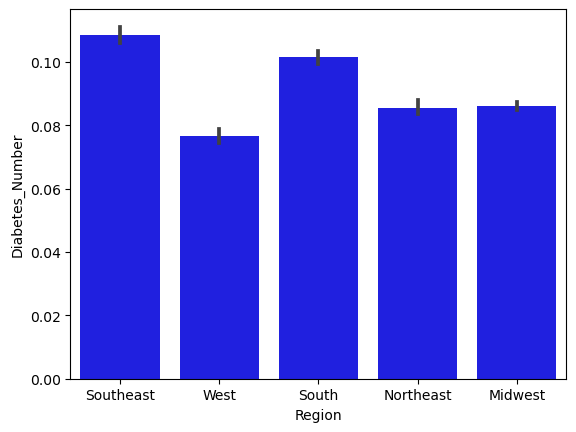

In [115]:
#
# EDA #1 and interpretations in this section 
#-----------
sns.barplot(x = "Region", 
            y = "Diabetes_Number", 
            data = diabetes, 
            color = "blue");


The southeast has a greater number of diabetes than any other region suggesting a higher concentration of predictive factors within the region. Variations in each region may be explained by differences in in other predictive factors. 

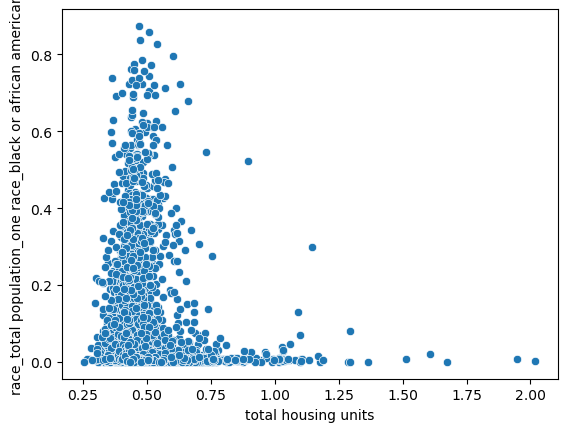

In [116]:
#
# EDA #2 and interpretations in this section 
#-----------
sns.scatterplot(x = "total housing units",
                y = "race_total population_one race_black or african american",
                data = diabetes);

This plot shows a seemingly linear relationship suggesting diabetes may increase with age so areas with older populations may have higher numbers of diabetes.

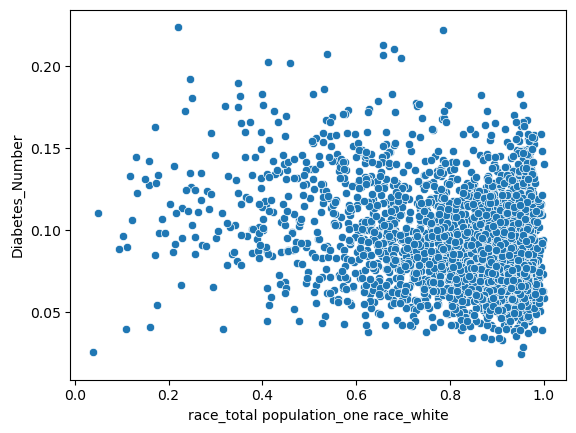

In [236]:
sns.scatterplot(x = "race_total population_one race_white",
                y = "Diabetes_Number",
                data = diabetes);

There appears to be a negative correlation between counties where with a large white population which may be explained by unobserved features like socioeconomic status.

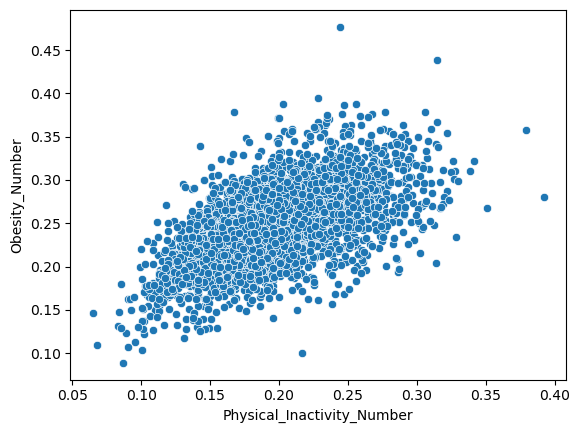

In [118]:
sns.scatterplot(x = "Physical_Inactivity_Number",
                y = "Obesity_Number",
                data = diabetes);

Obesity number and physical activity number appear to be colinear in our dataset. 

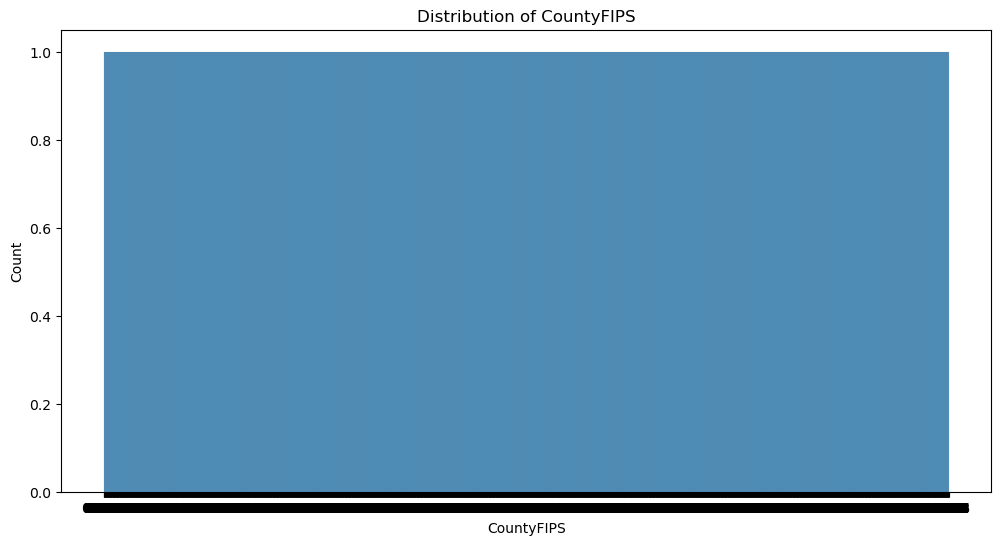

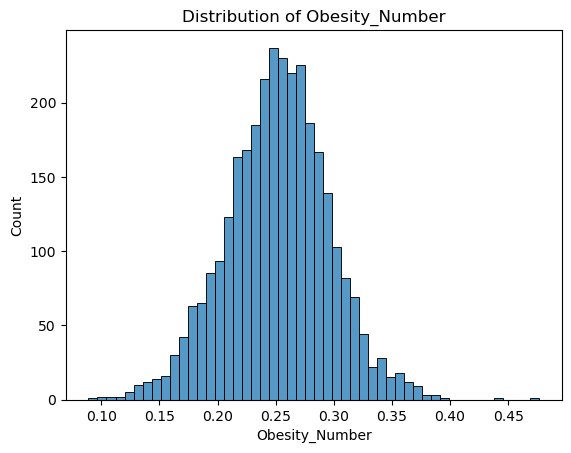

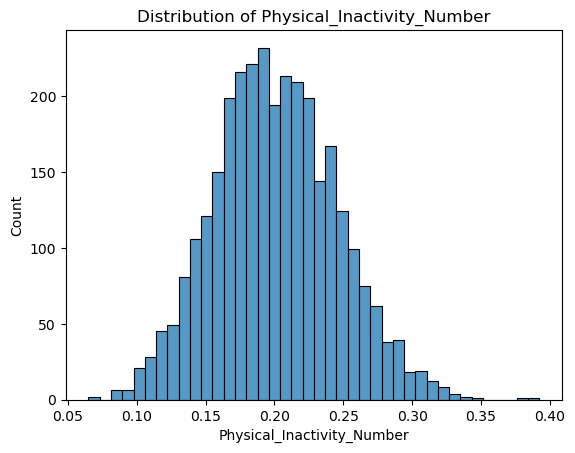

KeyError: 'sex_and_age_total_population_65_years_and_over_sex_ratio_(males_per_100_females)'

In [237]:
plt.figure(figsize=(12, 6))
for col in X.columns:
    sns.histplot(diabetes[col], kde=False)
    plt.title(f'Distribution of {col}')
    plt.show()

This f distrubtion shows how the frequencey of each feature in the dataset. It shows that the frequencey and distributions for the extended race and age categories may lack stastical power in our models.

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [120]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 

CountyFIPS  Diabetes_Number  Obesity_Number  Physical_Inactivity_Number  \
0      01001         0.093804        0.244366                    0.226902   
1      01003         0.080281        0.233255                    0.192324   
2      01005         0.131875        0.310643                    0.210651   
3      01007         0.105251        0.290052                    0.258667   
4      01009         0.108977        0.246804                    0.249198   
5      01011         0.224208        0.353748                    0.321967   
6      01013         0.145318        0.349513                    0.300974   
7      01015         0.127648        0.298580                    0.234140   
8      01017         0.141518        0.324425                    0.220570   
9      01019         0.122848        0.300429                    0.237342   

   sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  
5                                               73.6                                  
6                                               69.1                                  
7                                               73.7                                  
8                                               73.3                                  
9                                               86.7                                  

   race_total population  race_total population_one race  \
0                  55200                        0.981341   
1                 208107                        0.982836   
2                  25782                        0.986308   
3                  22527                        0.991699   
4                  57645                        0.983780   
5                  10352                        1.000000   
6                  20025                        0.983870   
7                 115098                        0.976229   
8                  33826                        0.989742   
9                  25853                        0.991955   

   race_total population_two or more races  \
0                                 0.018659   
1                                 0.017164   
2                                 0.013692   
3                                 0.008301   
4                                 0.016220   
5                                 0.000000   
6                                 0.016130   
7                                 0.023771   
8                                 0.010258   
9                                 0.008045   

   race_total population_one race_white  \
0                              0.768786   
1                              0.862662   
2                              0.473819   
3                              0.766547   
4                              0.955052   
5                              0.219861   
6                              0.520050   
7                              0.743349   
8                              0.575977   
9                              0.928209   

   race_total population_one race_black or african american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          
5                                           0.762461          
6                                           0.452185          
7                                           0.2057

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [121]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Diabetes_Number']

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(["Diabetes_Number", "race alone or in combination with one or more other races_total population"],
                 axis = 1)

X.head(10)

CountyFIPS  Obesity_Number  Physical_Inactivity_Number  \
0      01001        0.244366                    0.226902   
1      01003        0.233255                    0.192324   
2      01005        0.310643                    0.210651   
3      01007        0.290052                    0.258667   
4      01009        0.246804                    0.249198   
5      01011        0.353748                    0.321967   
6      01013        0.349513                    0.300974   
7      01015        0.298580                    0.234140   
8      01017        0.324425                    0.220570   
9      01019        0.300429                    0.237342   

   sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  
5                                               73.6                                  
6                                               69.1                                  
7                                               73.7                                  
8                                               73.3                                  
9                                               86.7                                  

   race_total population  race_total population_one race  \
0                  55200                        0.981341   
1                 208107                        0.982836   
2                  25782                        0.986308   
3                  22527                        0.991699   
4                  57645                        0.983780   
5                  10352                        1.000000   
6                  20025                        0.983870   
7                 115098                        0.976229   
8                  33826                        0.989742   
9                  25853                        0.991955   

   race_total population_two or more races  \
0                                 0.018659   
1                                 0.017164   
2                                 0.013692   
3                                 0.008301   
4                                 0.016220   
5                                 0.000000   
6                                 0.016130   
7                                 0.023771   
8                                 0.010258   
9                                 0.008045   

   race_total population_one race_white  \
0                              0.768786   
1                              0.862662   
2                              0.473819   
3                              0.766547   
4                              0.955052   
5                              0.219861   
6                              0.520050   
7                              0.743349   
8                              0.575977   
9                              0.928209   

   race_total population_one race_black or african american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          
5                                           0.762461          
6                                           0.452185          
7                                           0.205703          
8                                           0.393750          
9                                           0.049008          

   race_total population_one race_american indi

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

The plot above shows the distribution of each feature in the dataset. Some race categories such small frequencies I think conceptually and analytically it would make more sense to combine them (or in this case use the existing combines category), i.e. the American Indian and Alaskan Native tribal groupings. 
Total population as a variable I think would not fit conceptually the measures for the others are proportions of the county population. Many of these race variable categorization are not independent of eachother. I think the best way to preserve the 

In [130]:
X.columns = X.columns.str.replace("[-]", "_", regex=True)
X.columns = X.columns.str.replace("[ ]", "_", regex=True)
X_clean = X.drop(['hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_two_or_more_races_two_races_excluding_some_other_race____and_three_or_more_races'],
                axis = 1)
X.head(10)

CountyFIPS  Obesity_Number  Physical_Inactivity_Number  \
0      01001        0.244366                    0.226902   
1      01003        0.233255                    0.192324   
2      01005        0.310643                    0.210651   
3      01007        0.290052                    0.258667   
4      01009        0.246804                    0.249198   
5      01011        0.353748                    0.321967   
6      01013        0.349513                    0.300974   
7      01015        0.298580                    0.234140   
8      01017        0.324425                    0.220570   
9      01019        0.300429                    0.237342   

   sex_and_age_total_population_65_years_and_over_sex_ratio_(males_per_100_females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  
5                                               73.6                                  
6                                               69.1                                  
7                                               73.7                                  
8                                               73.3                                  
9                                               86.7                                  

   race_total_population  race_total_population_one_race  \
0                  55200                        0.981341   
1                 208107                        0.982836   
2                  25782                        0.986308   
3                  22527                        0.991699   
4                  57645                        0.983780   
5                  10352                        1.000000   
6                  20025                        0.983870   
7                 115098                        0.976229   
8                  33826                        0.989742   
9                  25853                        0.991955   

   race_total_population_two_or_more_races  \
0                                 0.018659   
1                                 0.017164   
2                                 0.013692   
3                                 0.008301   
4                                 0.016220   
5                                 0.000000   
6                                 0.016130   
7                                 0.023771   
8                                 0.010258   
9                                 0.008045   

   race_total_population_one_race_white  \
0                              0.768786   
1                              0.862662   
2                              0.473819   
3                              0.766547   
4                              0.955052   
5                              0.219861   
6                              0.520050   
7                              0.743349   
8                              0.575977   
9                              0.928209   

   race_total_population_one_race_black_or_african_american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          
5                                           0.762461          
6                                           0.452185          
7                                           0.205703          
8                                           0.393750          
9                                           0.049008          

   race_total_population_one_race_american_indi

In [175]:

# Feature selection
X_clean = X.drop(['CountyFIPS',
                 'race_total_population_one_race',
                  'race_total_population',
                 'race_total_population_one_race_american_indian_and_alaska_native_cherokee_tribal_grouping',
                 'race_total_population_one_race_american_indian_and_alaska_native_sioux_tribal_grouping',
                 'race_total_population_one_race_american_indian_and_alaska_native_chippewa_tribal_grouping',
                 'race_total_population_one_race_american_indian_and_alaska_native_navajo_tribal_grouping',
                 'race_total_population_one_race_asian_asian_indian',
                 'race_total_population_one_race_asian_chinese',
                 'race_total_population_one_race_asian_filipino',
                 'race_total_population_one_race_asian_japanese',
                 'race_total_population_one_race_asian_korean',
                 'race_total_population_one_race_asian_vietnamese',
                  'race_total_population_one_race_asian_other_asian',
                  'race_total_population_one_race_native_hawaiian_and_other_pacific_islander_native_hawaiian',
                  'race_total_population_one_race_native_hawaiian_and_other_pacific_islander_guamanian_or_chamorro',
                  'race_total_population_one_race_native_hawaiian_and_other_pacific_islander_samoan',
                  # 'hispanic_or_latino_and_race_total_population',
                  'hispanic_or_latino_and_race_total_population_not_hispanic_or_latino',
                  'hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_white_alone',
                  'hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_black_or_african_american_alone',
                   'hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_american_indian_and_alaska_native_alone',
                 'hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_asian_alone',
                 'hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_native_hawaiian_and_other_pacific_islander_alone',
                  'hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_some_other_race_alone',
                  'hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_two_or_more_races',
                  'hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_two_or_more_races_two_races_including_some_other_race',
                  'hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_two_or_more_races_two_races_including_some_other_race',
                  'hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_two_or_more_races_two_races_excluding_some_other_race____and_three_or_more_races',
                  #'hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_two_or_more_races_two_races_excluding_some_other_race___and_three_or_more_races',
                 # 'race_total_population_two_or_more_races_white_and_black_or_african_american',
                 # 'race_total_population_two_or_more_races_white_and_american_indian_and_alaska_native',
                 # 'race_total_population_two_or_more_races_white_and_asian',
                 # 'race_total_population_two_or_more_races_black_or_african_american_and_american_indian_and_alaska_native',
                  'race_alone_or_in_combination_with_one_or_more_other_races_total_population_white',
                  'race_alone_or_in_combination_with_one_or_more_other_races_total_population_black_or_african_american',
                  'race_alone_or_in_combination_with_one_or_more_other_races_total_population_american_indian_and_alaska_native',
                  'race_alone_or_in_combination_with_one_or_more_other_races_total_population_asian',
                  'race_alone_or_in_combination_with_one_or_more_other_races_total_population_native_hawaiian_and_other_pacific_islander',
                  'race_alone_or_in_combination_with_one_or_more_other_races_total_population_some_other_race',
                  'hispanic_or_latino_and_race_total_population_hispanic_or_latino_(of_any_race)_mexican',
                  'hispanic_or_latino_and_race_total_population_hispanic_or_latino_(of_any_race)_puerto_rican',
                  'hispanic_or_latino_and_race_total_population_hispanic_or_latino_(of_any_race)_cuban',
                  'hispanic_or_latino_and_race_total_population_hispanic_or_latino_(of_any_race)_other_hispanic_or_latino',
                  #'race_total_population_two_or_more_races_1',
                  'citizen____voting_age_population_citizen____18_and_over_population',
                  'citizen____voting_age_population_citizen____18_and_over_population_male',
                  'citizen____voting_age_population_citizen____18_and_over_population_female',
                #  'sex_and_age_total_population',
                  'sex_and_age_total_population_male',
                  'sex_and_age_total_population_female',
                  'sex_and_age_total_population_median_age_(years)',
                  'sex_and_age_total_population_under_18_years',
                  'sex_and_age_total_population_16_years_and_over',
                  'sex_and_age_total_population_18_years_and_over',
                  'sex_and_age_total_population_21_years_and_over',
                  'sex_and_age_total_population_62_years_and_over',
                  'sex_and_age_total_population_65_years_and_over',
                 # 'sex_and_age_total_population_18_years_and_over_1',
                  'sex_and_age_total_population_18_years_and_over_male',
                  'sex_and_age_total_population_18_years_and_over_female',
                  'sex_and_age_total_population_18_years_and_over_sex_ratio_(males_per_100_females)',
                 # 'sex_and_age_total_population_65_years_and_over_1',
                  'sex_and_age_total_population_65_years_and_over_male', 
                  'sex_and_age_total_population_65_years_and_over_female'],
                axis =1
                )
X_clean.head(10)

Obesity_Number  Physical_Inactivity_Number  \
0        0.244366                    0.226902   
1        0.233255                    0.192324   
2        0.310643                    0.210651   
3        0.290052                    0.258667   
4        0.246804                    0.249198   
5        0.353748                    0.321967   
6        0.349513                    0.300974   
7        0.298580                    0.234140   
8        0.324425                    0.220570   
9        0.300429                    0.237342   

   sex_and_age_total_population_65_years_and_over_sex_ratio_(males_per_100_females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  
5                                               73.6                                  
6                                               69.1                                  
7                                               73.7                                  
8                                               73.3                                  
9                                               86.7                                  

   race_total_population_two_or_more_races  \
0                                 0.018659   
1                                 0.017164   
2                                 0.013692   
3                                 0.008301   
4                                 0.016220   
5                                 0.000000   
6                                 0.016130   
7                                 0.023771   
8                                 0.010258   
9                                 0.008045   

   race_total_population_one_race_white  \
0                              0.768786   
1                              0.862662   
2                              0.473819   
3                              0.766547   
4                              0.955052   
5                              0.219861   
6                              0.520050   
7                              0.743349   
8                              0.575977   
9                              0.928209   

   race_total_population_one_race_black_or_african_american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          
5                                           0.762461          
6                                           0.452185          
7                                           0.205703          
8                                           0.393750          
9                                           0.049008          

   race_total_population_one_race_american_indian_and_alaska_native  \
0                                           0.002880                  
1                                           0.007314                  
2                                           0.002793                  
3                                           0.000355                  
4                                           0.002446                  
5                                           0.011785                  
6                                           0.000100                  
7                                           0.003067                  
8                                           0.002868                  
9                                           0.009129                  

   race_total_population_one_race_asian  \
0    

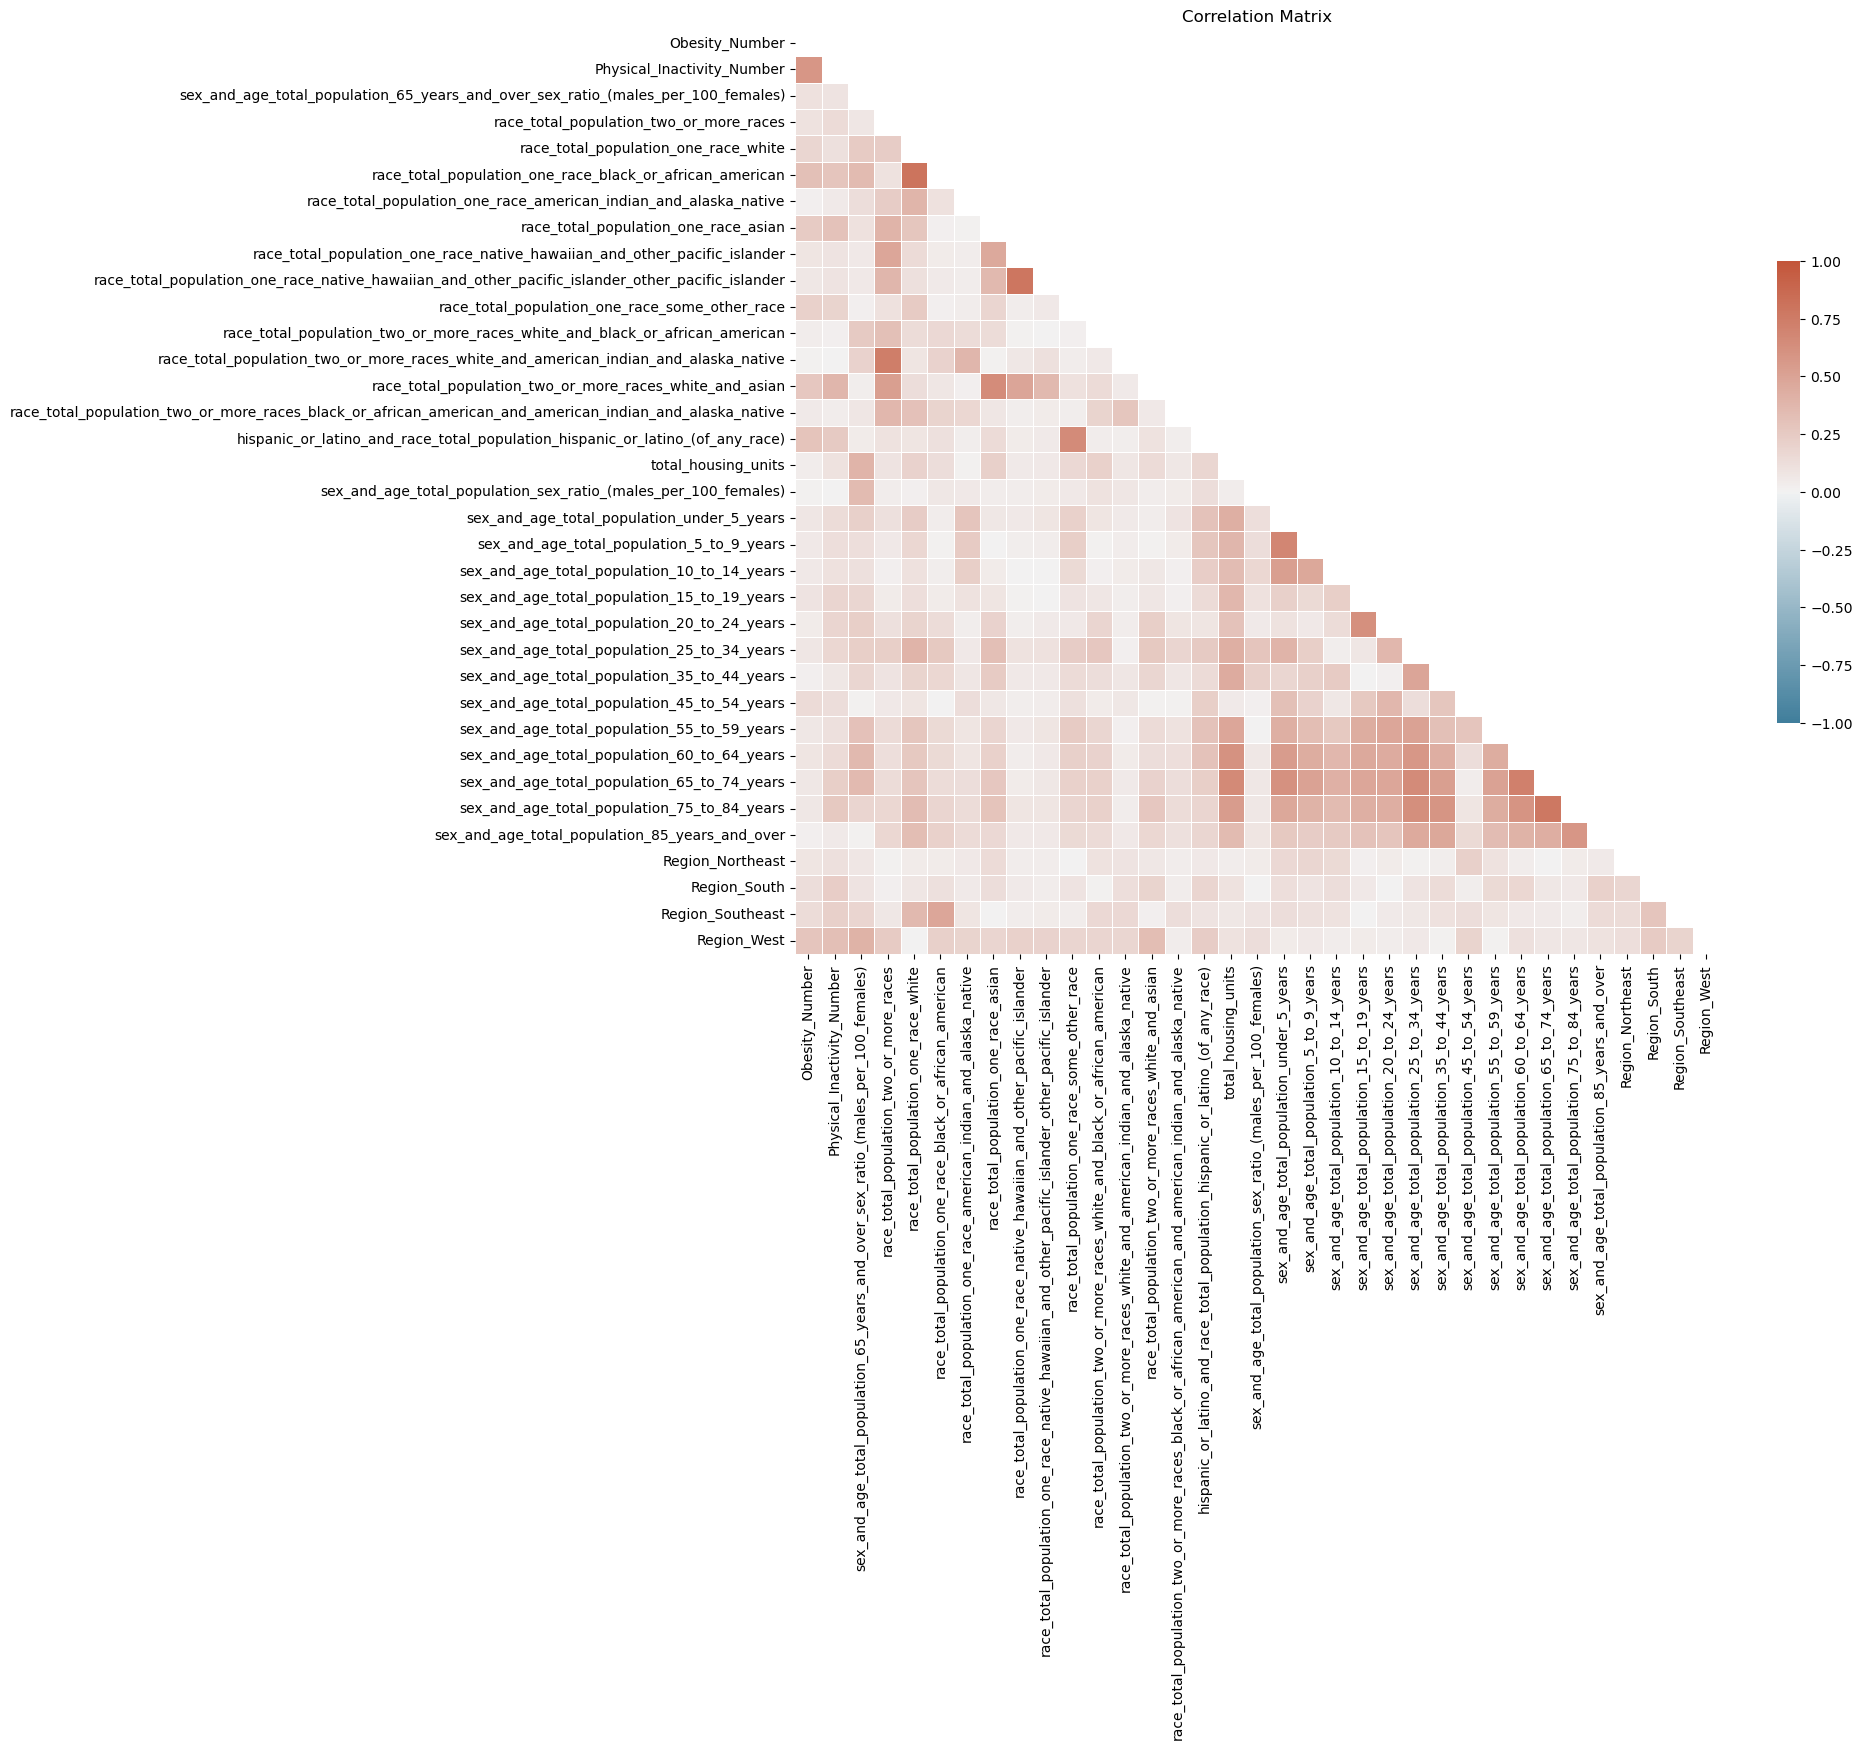

In [176]:
#
# Feature selection
#-----------
corr_matrix = X_clean.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(15, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})
plt.title('Correlation Matrix')
plt.show()
 

In [177]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data 
X_train, X_test, y_train, y_test = train_test_split(X_clean,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size= 0.8,      # specify proportional split for training
                                                    test_size= 0.2)       # specify proportional split for test

In [178]:
#
# Validation split
#----------- 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train,
                                                             y_train,
                                                             train_size = .75,
                                                             test_size = .25)

In [179]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very high penalty (very low, like alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

Linear Regression: The logic behind linear regression lies in capturing the direct linear relationships between age, race, and sex proportions and diabetes. It assumes a simple, additive relationship, making it interpretable and suitable when the impact of each demographic factor is expected to be consistent.

Ridge Regression: Ridge regression extends linear regression by introducing a regularization term that penalizes large coefficients. The logic here is to control for multicollinearity among age, race, and sex proportions, promoting a more stable and generalizable model. It balances the trade-off between fitting the data well and preventing overemphasis on specific features.

LASSO's logic aligns with feature selection. By adding a penalty term based on the absolute values of the coefficients, LASSO tends to shrink less influential features to zero. This is advantageous when certain demographic factors may have a more pronounced impact on diabetes, allowing for a streamlined and interpretable model.

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  Linear Regression 

[ 8.28183196e-03  7.32361076e-03 -1.73470063e-03 -2.22805803e+10
 -1.82557550e+11 -1.60205677e+11 -7.96835087e+10 -3.02930421e+10
 -5.20401775e+09  6.44001682e-04 -4.03966771e+10 -5.31872016e-04
 -2.57110417e-03 -2.12978783e-03  8.19982878e-04  7.89537454e-04
 -9.65546320e-04 -8.66673002e-04  9.25849190e+10  9.46384061e+10
  9.29454524e+10  1.08950710e+11  1.82739576e+11  1.79636994e+11
  1.21779708e+11  1.14621812e+11  9.48681379e+10  1.07337610e+11
  2.03501276e+11  1.28607683e+11  7.09213595e+10  5.06292270e-03
  6.50131126e-03  7.68824960e-03  2.70825718e-03]
0.0899620479418444


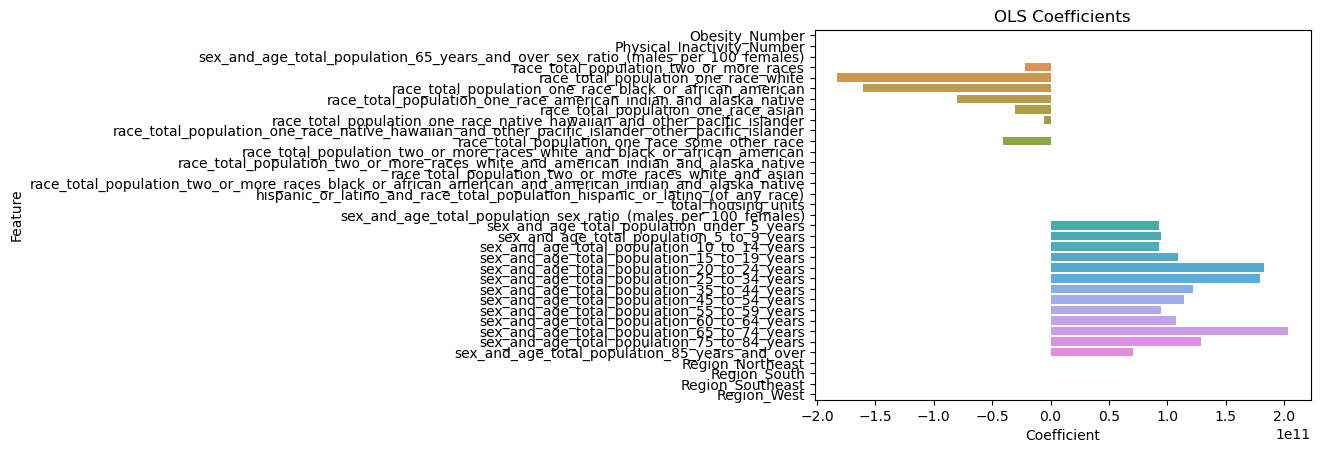

In [180]:

from sklearn.linear_model import Ridge, Lasso, LinearRegression
# Model 1 training
#-----------
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train, y_train)

print(lin_model.coef_)
print(lin_model.intercept_)

lin_reg_data = pd.DataFrame([lin_model.coef_, X_clean.columns]).T 
lin_reg_data.columns = ['Coefficient', 'Feature']           

# plot
ax = sns.barplot(x="Coefficient",                            
                 y="Feature",                               
                 data=lin_reg_data)                        

ax.set_title("OLS Coefficients")                            
plt.show()  


#### Model 2:  Ridge Regression

[ 8.27326055e-03  7.27391455e-03 -1.64304818e-03  3.15365627e-03
 -3.29322063e-03  2.89424481e-03  1.85008261e-03 -9.46158071e-04
  2.72040644e-05  5.36440217e-04 -1.27827572e-03 -2.68348524e-04
 -3.03311163e-03 -2.76453848e-03 -4.37662180e-04  9.36473687e-05
 -1.06552696e-03 -3.34301867e-04 -1.60306455e-03 -1.23554815e-03
  5.19131872e-04  6.16308923e-04 -2.34982381e-03 -9.42553075e-04
 -6.27494803e-04  4.42451672e-04 -7.95487540e-06 -6.20241612e-04
  4.01638739e-03  8.32967232e-04 -1.16692111e-03  1.23732386e-03
  7.39110089e-03  7.00206571e-03  3.08288678e-03]
0.08985918009481679


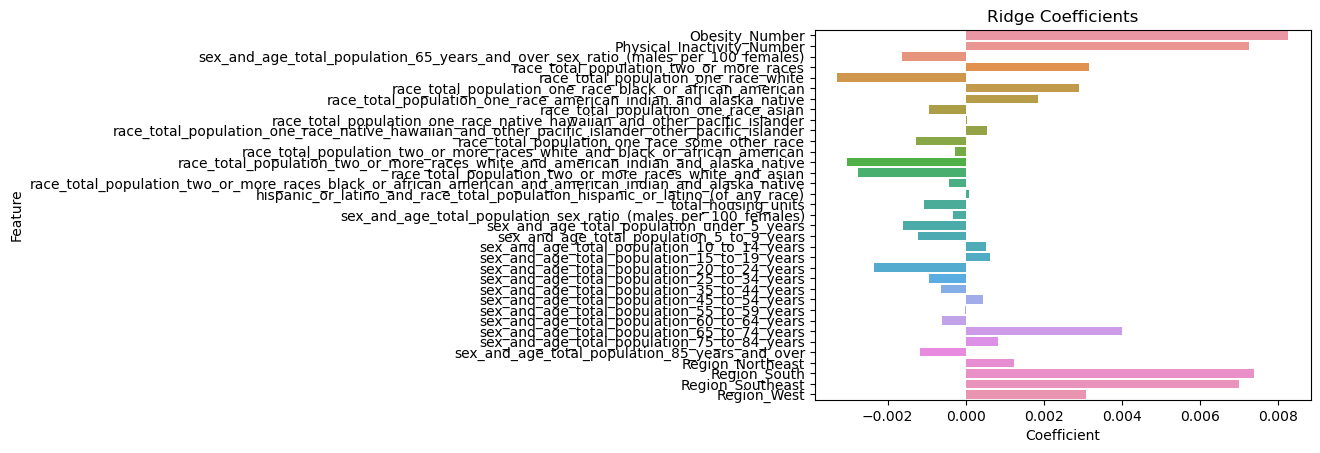

In [210]:
#
# Model 2 training
#-----------
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# create a dataframe with the coefficient and feature names for plotting
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X_clean.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature'] 

print(ridge_model.coef_)
print(ridge_model.intercept_)


# specify barplot for Ridge
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=ridge_reg_data).set_title("Ridge Coefficients")

# show the plots
plt.show()

#### Model 3:  LASSO Regression

[ 8.08938743e-03  7.41778745e-03 -1.39638550e-03  0.00000000e+00
 -6.83357658e-03  0.00000000e+00  4.73982698e-05 -1.31702176e-03
  8.18982327e-04  2.17858833e-04 -1.68228972e-03  2.68087358e-04
 -9.30488752e-04 -1.84078041e-03 -1.12087179e-04  4.42038863e-05
 -8.48152686e-04 -2.94539582e-04 -1.03291696e-03 -7.45547870e-04
  8.36177392e-04  9.09029458e-04 -1.41458049e-03 -1.89755120e-04
 -0.00000000e+00  8.56231966e-04  1.01175177e-04 -0.00000000e+00
  4.99437660e-03  1.05631009e-03 -8.15563182e-04  0.00000000e+00
  5.79281190e-03  5.29252301e-03  7.04245096e-04]
0.09103087343880852


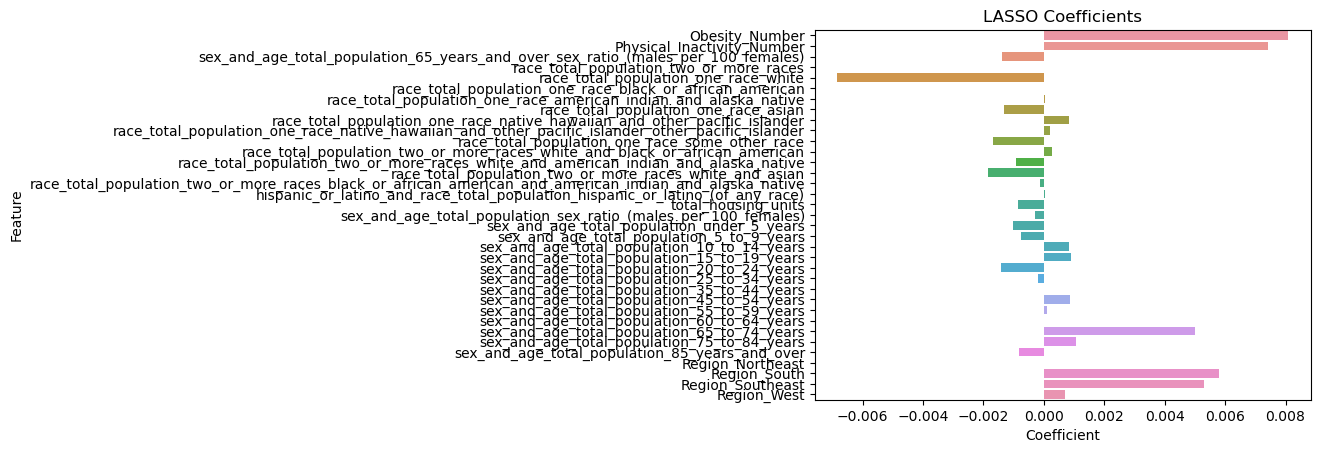

In [187]:
#
# Model 3 training
#-----------
lasso_reg = Lasso(alpha=.0001)  
lasso_model = lasso_reg.fit(X_train, 
                            y_train)

# create a dataframe 
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X_clean.columns]).T  
lasso_reg_data.columns = ['Coefficient', 'Feature']

print(lasso_model.coef_)
print(lasso_model.intercept_)


sns.barplot(x="Coefficient", 
            y="Feature", 
            data=lasso_reg_data).set_title("LASSO Coefficients")

plt.show()

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

In [196]:
# import library 
from sklearn.metrics import mean_squared_error

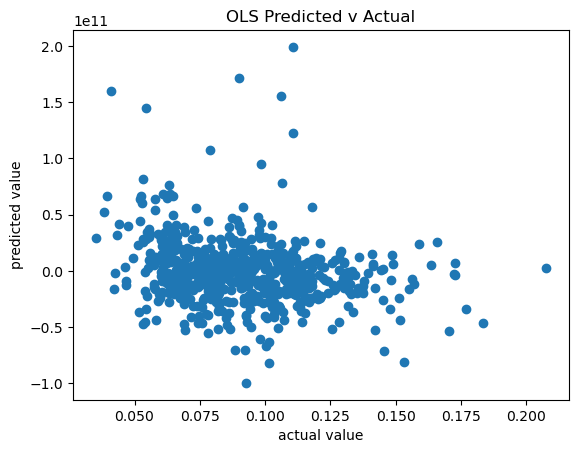

In [204]:
#Linear Model (OLS)
# Predict on validation data
#-----------

 
lin_pred = lin_model.predict(X_validate)

# plot the residuals on a scatter plot
plt.scatter(y_validate, lin_pred)                    
plt.title('OLS Predicted v Actual')  
plt.xlabel('actual value')                         
plt.ylabel('predicted value')                        
plt.show()  

In [234]:
print(mean_squared_error(lin_pred,
                         y_validate, 
                         squared = False))

29882188911.440456


The RMSE of 29882188911.440456 is inidicative of a substantiial level of error prediction in the model. The model has high sensitivity to multicolinearity. There are many features like inactivity and obesity that are colinear. The data set also included many variables that were different measures of population for sex, race, and age.

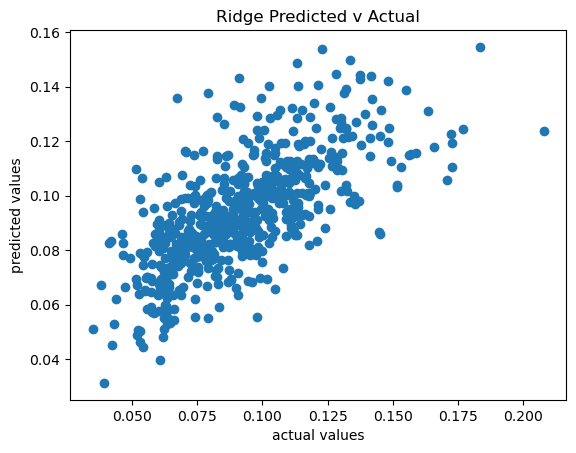

In [211]:
#Ridge Regression


ridge_pred = ridge_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Predicted v Actual')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [212]:
print(mean_squared_error(ridge_pred,
                         y_validate, 
                         squared = False)) 

0.019151328161832553


This model performed exceptionally better than the linear model as the RMSE is substantially smaller. 

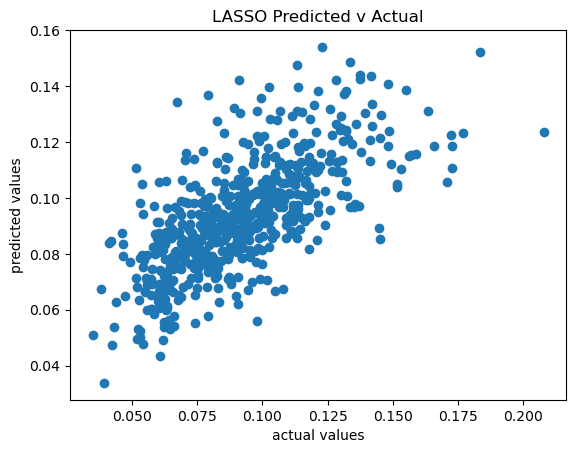

In [213]:
# LASSO Model

lasso_pred = lasso_model.predict(X_validate)

plt.scatter(y_validate, lasso_pred)


plt.title('LASSO Predicted v Actual')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [214]:
print(mean_squared_error(lasso_pred,
                         y_validate, 
                         squared = False))


0.019109395545166746


The RMSE for the LASSO model performs near identical to the ridge regression.

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [231]:
# Best Ridge model 

# pick the best estimator and predict on test
best_pred = ridge_grid_reg.best_estimator_.predict(X_test)

# print various results
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2:', ridge_grid_reg.score(X_test, y_test))
print('Test RMSE', rmse(best_pred, y_test))

Best CV R^2: 0.49867653234033665
Test R^2: 0.4397375220095212
Test RMSE 0.02062962675114801


### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [233]:

# Run cross-validation

# run 9*2*4 = 72 tests, each with 10-fold cross validation

# hyperparameter specs
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=10)       # 10 fold cross-validation t

# fit the tuning on the training data
    ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  #  best performing model
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)   # find best estimator and predict on validate

#results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_validate))


{'alpha': 0.9, 'fit_intercept': True, 'solver': 'lsqr'}
Best CV R^2: 0.49718594530244
Validation R^2: 0.4584589230158387
Validation RMSE 0.01915221501860077


## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

The bias-variance tradeoff is like walking a tightrope in machine learning. Bias is when your model oversimplifies, missing the nuances of the data. Variance is when it's too flexible, fitting the noise instead of the signal. Balancing them is crucial; too much bias means you're ignoring important patterns, too much variance means you're just memorizing the training data. In this diabetes prediction game, finding the sweet spot ensures your model generalizes well to new data without being a know-it-all or a scatterbrain. It's about being the Goldilocks of algorithms—not too simple, not too complex, just right.

2. Define overfitting, and why it matters for machine learning. How can we address it?

Overfitting in machine learning occurs when a model learns the training data too well, capturing noise and specific details that don't generalize to new data. It matters because an overfit model may perform poorly on unseen data. To address overfitting, techniques like regularization, cross-validation, and pruning are used to ensure the model generalizes effectively.

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

The Ridge regression model with the hyperparameters {'alpha': 0.9, 'fit_intercept': True, 'solver': 'lsqr'} has a moderate performance. During cross-validation, it explains about 49.7% of the variance in the training data, and on a separate validation set it has the predictive power of about 45.8%. The low validation RMSE of 0.01915221501860077 suggests the model has accurate prediction.

Based on this perfomrance, I would suggest the pilot program prioritize the South and/or the the South east regions. other important features of counties within those regions are counties with high rates of obesity or high rates of physical inactivity. The pilot program should also consider counties with significant proportions of Black and African American residents and counties with a high proportion of non-white residents as well as counties with older residents around 65-74. 

This analysis was based on variables that only include race, sex, ethnicity, obesity, and physical inactivity at the county level. There are a few concersn I have in using this model for a real world application. Firstly, the model only has 45.8% predictive power. I think to accuratley predict diabetes other considerations should be made in data collection that have a clearer causal relationship to our outcome such as diet and access to healthcare (such as primary care facility density per county). 
